In [1]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import functorch

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class DNN(torch.nn.Module):
    
    def __init__(self, input_dim=1, output_dim=1):
        super(DNN, self).__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, output_dim)
        )
        
    def forward(self, x):
        return self.nn(x)

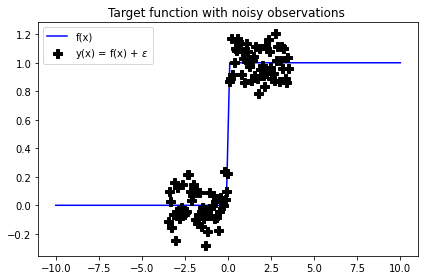

In [5]:
np.random.seed(123)
sigma_n = 0.1

# Test inputs
X_train = np.linspace(-3.5, 3.5, 100).reshape(-1,1)
X_test = np.linspace(-10, 10, 100).reshape(-1, 1)

f_train = np.heaviside(X_train, 0)
f_test = np.heaviside(X_test, 0)

y_train = f_train + sigma_n * np.random.randn(*f_train.shape)
y_test = f_test # No need for noise I guess

# Noisy observations
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test, y_test, 'b', label = 'f(x)')
ax.plot(X_train, y_train, 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

In [6]:
X_train = torch.tensor(X_train, device=device, dtype=torch.float)
X_test = torch.tensor(X_test, device=device, dtype=torch.float)

y_train = torch.tensor(y_train, device=device, dtype=torch.float)
y_test = torch.tensor(y_test, device=device, dtype=torch.float)

In [7]:
model = DNN().to(device)
func_model, params = functorch.make_functional(model)
param_sizes = [p.shape for p in params]
dim = sum([math.prod(s)for s in param_sizes])
N = 100

idx_to = np.cumsum([math.prod(s) for s in param_sizes])
idx_from = np.zeros(len(idx_to), dtype=int)
idx_from[1:] = idx_to[:-1]

def get_params_from_array(array):
    return [array[idx_from[i]:idx_to[i]].reshape(s) for i, s in enumerate(param_sizes)]
    
sigma2 = 0.1

def log_prior(params):
    return -torch.sum(params**2) / (2 * sigma2)

def log_likelihood(x, y, params):
    preds = func_model(get_params_from_array(params), x)
    diff = preds - y
    
    return - torch.sum(diff**2) / (2 * sigma_n**2)

def log_posterior(x, y, params):
    return log_prior(params) + (N / x.shape[0]) * log_likelihood(x, y, params)

def log_posterior_batch(x, y, params_batch):
    func = lambda params: log_posterior(x, y, params)
    func = functorch.vmap(func)
    return func(params_batch)

In [8]:
class SDE(torch.nn.Module):
    
    def __init__(self, gamma, input_dim, width=300):
        super().__init__()
        activation = torch.nn.Softplus
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim + 1, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, input_dim)
        )
        
        self.nn[-1].weight.data.fill_(0)
        self.nn[-1].bias.data.fill_(0)
        
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        
        self.gamma = gamma
    
    def f(self, t, params_batch):
        t_ = t * torch.ones((params_batch.shape[0], 1), device=params_batch.device)
        return self.nn(torch.cat((t_, params_batch), dim=-1))
    
    def g(self, t, params_batch):
        return torch.sqrt(self.gamma * torch.ones_like(params_batch))

In [9]:
def loss(sde, x, y, dt=0.05):
    n_steps = int(1.0 / dt)
    ts = torch.linspace(0, 1, n_steps, device=device)
    
    param_init = torch.zeros((param_batch_size, dim), device=device)
    param_trajectory = torchsde.sdeint(sde, param_init, ts, method="euler", dt=dt)
    param_T = param_trajectory[-1]
    
    fs = functorch.vmap(sde.f)(ts, param_trajectory)
    
    energy_cost = torch.sum(fs**2, dim=[0, 2]) * dt  / (2 * gamma)
    terminal_cost = - torch.sum(param_T**2, dim=1) / (2 * gamma) - log_posterior_batch(x, y, param_T)
    
    return torch.mean(energy_cost + terminal_cost)

In [10]:
gamma = 0.05**2
sde = SDE(gamma, dim).to(device)

optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)

n_steps = 300
data_batch_size = 50
param_batch_size = 32

In [11]:
losses = []

for _ in tqdm(range(n_steps)):
    perm = torch.randperm(100)
    x = X_train[perm[:50], :]
    y = y_train[perm[:50], :]
    
    optimizer.zero_grad()
    l = loss(sde, x, y, dt=0.05)
    l.backward()
    losses.append(l.detach().cpu().numpy())
    optimizer.step()

  0%|                                                                        | 0/300 [00:00<?, ?it/s]/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-b9xxrrfi/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
100%|██████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 30.04it/s]


In [12]:
losses = np.array(losses)

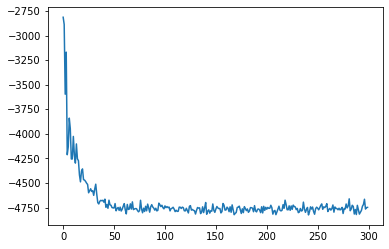

In [13]:
plt.plot(losses.flatten())

In [40]:
with torch.no_grad():
    dt = 0.005
    n_steps = int(1.0 / dt)
    ts = torch.linspace(0, 1, n_steps, device=device)
    
    param_init = torch.zeros((50, dim), device=device)
    param_trajectory = torchsde.sdeint(sde, param_init, ts, method="euler", dt=dt)
    param_samples = param_trajectory[-1]

In [41]:
with torch.no_grad():
    predict_func = lambda params : func_model(get_params_from_array(params), X_test)
    predict_func = functorch.vmap(predict_func)

    preds = predict_func(param_samples)
    std = torch.std(preds, dim=0)
    preds = torch.mean(preds, dim=0)

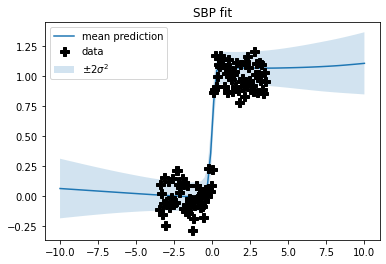

In [43]:
plt.plot(X_test.cpu().squeeze(), preds.cpu().numpy())
plt.fill_between(X_test.cpu().squeeze(), (preds - 2 * std).cpu().squeeze(), (preds + 2 * std).cpu().squeeze(), alpha=0.2)
plt.plot(X_train.cpu(), y_train.cpu(), 'kP', ms = 9)
plt.title("SBP fit")
plt.legend(["mean prediction", "data", r"$\pm 2\sigma^2$"])
plt.savefig("plots/sbp_step_func_fit.png", bbox_inches="tight", dpi=600)

In [44]:
@torch.enable_grad()
def gradient(x, y, params):
    params_ = params.clone().requires_grad_(True)
    loss = log_posterior(x, y, params_)
    grad, = torch.autograd.grad(loss, params_)
    return loss.detach().cpu().numpy(), grad

In [45]:
def step_size(n):
    return 1e-4/ (1 + n)**0.1

In [72]:
params = torch.zeros(dim).float().to(device)
n_steps = 10000

In [73]:
losses = []

for step in tqdm(range(n_steps)):
    perm = torch.randperm(100)
    x = X_train[perm[:50], :]
    y = y_train[perm[:50], :]
    
    eps = step_size(step)
    loss, grad = gradient(x, y, params)
    params = params + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(params)
    
    losses.append(loss)

100%|████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.61it/s]


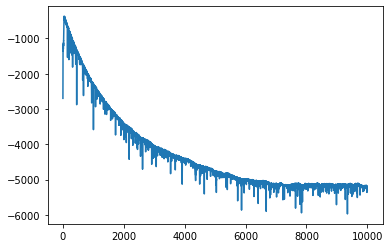

In [74]:
plt.plot(losses)

In [75]:
preds = func_model(get_params_from_array(params), X_test)

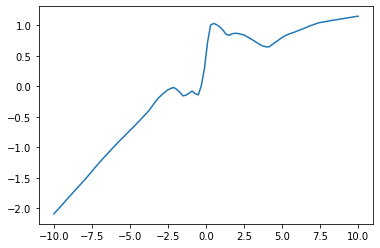

In [76]:
plt.plot(X_test.cpu(), preds.cpu())

In [85]:
params_samples = []

for i in range(1000):
    perm = torch.randperm(100)
    x = X_train[perm[:50], :]
    y = y_train[perm[:50], :]
        
    eps = step_size(step)
    loss, grad = gradient(x, y, params)
    params = params + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(params)
    step += 1
    params_samples.append(params)

In [86]:
params_samples = torch.stack(params_samples)

In [87]:
with torch.no_grad():
    predict_func = lambda params : func_model(get_params_from_array(params), X_test)
    predict_func = functorch.vmap(predict_func)

    preds = predict_func(params_samples)
    std = torch.std(preds, dim=0)
    preds = torch.mean(preds, dim=0)

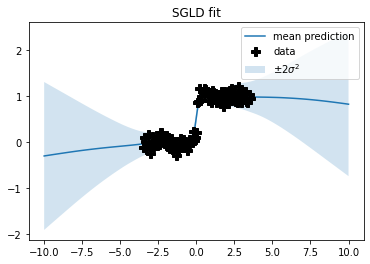

In [88]:
plt.plot(X_test.cpu().squeeze(), preds.cpu().numpy())
plt.fill_between(X_test.cpu().squeeze(), (preds - 2 * std).cpu().squeeze(), (preds + 2 * std).cpu().squeeze(), alpha=0.2)
plt.plot(X_train.cpu(), y_train.cpu(), 'kP', ms = 9)
plt.title("SGLD fit")
plt.legend(["mean prediction", "data", r"$\pm 2\sigma^2$"])
plt.savefig("plots/sgld_step_func_fit_1000.png", bbox_inches="tight", dpi=600)